In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load the dataset
transaction_df = pd.read_excel('/content/drive/MyDrive/Quantum_analytics/QVI_transaction_data.xlsx')
transaction_df.head(1)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0


In [4]:
#load dataset
behaviour_df = pd.read_csv('/content/drive/MyDrive/Quantum_analytics/QVI_purchase_behaviour.csv')
behaviour_df.head(1)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium


## Exploratory data analysis

In [5]:
#Check for datatypes in transaction dataframe
transaction_df.dtypes

,0
DATE,int64
STORE_NBR,int64
LYLTY_CARD_NBR,int64
TXN_ID,int64
PROD_NBR,int64
PROD_NAME,object
PROD_QTY,int64
TOT_SALES,float64


We can see that the date column in an integer format. Let’s change this to a date format.

In [6]:
# Convert the date column from int to datetime
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], origin='1899-12-30', unit='D')
print(transaction_df['DATE'].dtype)

datetime64[ns]


Lets check that we are looking at the right products by examining PROD_NAME.

In [7]:
# Count occurrences of each unique product name
product_counts = transaction_df['PROD_NAME'].value_counts().reset_index()
product_counts.columns = ['PROD_NAME', 'Count']
product_counts = product_counts.sort_values('Count', ascending=False)
print(product_counts)


                                    PROD_NAME  Count
0      Kettle Mozzarella   Basil & Pesto 175g   3304
1    Kettle Tortilla ChpsHny&Jlpno Chili 150g   3296
2    Cobs Popd Swt/Chlli &Sr/Cream Chips 110g   3269
3      Tyrrells Crisps     Ched & Chives 165g   3268
4              Cobs Popd Sea Salt  Chips 110g   3265
..                                        ...    ...
109                  RRD Pc Sea Salt     165g   1431
110            Woolworths Medium   Salsa 300g   1430
111    NCC Sour Cream &    Garden Chives 175g   1419
112            French Fries Potato Chips 175g   1418
113         WW Crinkle Cut      Original 175g   1410

[114 rows x 2 columns]


Looks like we are definitely looking at potato chips but how can we check that these are all chips? Lets
do some basic text analysis by summarising the individual words in the product name.

In [8]:
# Examine the words in PROD_NAME to see if there are any incorrect entries
# such as products that are not chips
unique_prod_names = transaction_df['PROD_NAME'].unique()
# Split product names into words and flatten the list
all_words = [word for name in unique_prod_names for word in name.split()]
# Create a DataFrame with these words
product_words = pd.DataFrame(all_words, columns=['words'])
print(product_words.head())

         words
0      Natural
1         Chip
2       Compny
3  SeaSalt175g
4          CCs


As we are only interested in words that will tell us if the product is chips or not, let’s remove all words with
digits and special characters such as ‘&’ from our set of product words.

In [9]:
# Removing digits
product_words = product_words[~product_words['words'].str.contains(r'\d')]

# Removing special characters (keeping only words with alphabetic characters)
product_words = product_words[product_words['words'].str.match(r'^[a-zA-Z]+$')]

# Counting word frequencies and sorting by frequency in descending order
word_counts = product_words['words'].value_counts().reset_index()
word_counts.columns = ['words', 'count']
word_counts = word_counts.sort_values('count', ascending=False)
print(word_counts)

         words  count
0        Chips     21
1       Smiths     16
2      Crinkle     14
3          Cut     14
4       Kettle     13
..         ...    ...
99      Vingar      1
98         Veg      1
97       Strws      1
96       Mango      1
167  Bolognese      1

[168 rows x 2 columns]


There are salsa products in the dataset but we are only interested in the chips category, so let’s remove
these.

In [10]:
# Remove salsa products
# Convert 'Product_Name' to lowercase and check for the presence of 'salsa'
transaction_df['SALSA'] = transaction_df['PROD_NAME'].str.lower().str.contains('salsa')
transaction_df = transaction_df[transaction_df['SALSA'] == False]
transaction_df = transaction_df.drop(columns=['SALSA'])
transaction_df.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9



Lets use describe to check for summary statistics and outliers


In [11]:
transaction_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


In [12]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246742 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            246742 non-null  datetime64[ns]
 1   STORE_NBR       246742 non-null  int64         
 2   LYLTY_CARD_NBR  246742 non-null  int64         
 3   TXN_ID          246742 non-null  int64         
 4   PROD_NBR        246742 non-null  int64         
 5   PROD_NAME       246742 non-null  object        
 6   PROD_QTY        246742 non-null  int64         
 7   TOT_SALES       246742 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.9+ MB


There are no nulls in the columns but product quantity appears to have an outlier which we should investigate
further. Let’s investigate further the case where 200 packets of chips are bought in one transaction.


In [13]:
# Filter the dataset to find the outlier
outlier = transaction_df[transaction_df['PROD_QTY'] == 200]
print(outlier)

            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


There are two transactions where 200 packets of chips are bought in one transaction and both of these
transactions where by the same customer.

In [14]:
## Let's see if the customer has had other transactions
suspect_customer = transaction_df[transaction_df['LYLTY_CARD_NBR'] == 226000]
suspect_customer

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It looks like this customer has only had the two transactions over the year and is not an ordinary retail
customer. The customer might be buying chips for commercial purposes instead. Lets remove this loyalty
card number from further analysis.

In [15]:
#drop the suspect customer from transaction dataframe
transaction_df = transaction_df[transaction_df['LYLTY_CARD_NBR'] != 226000]

In [16]:
transaction_df['PROD_QTY'].describe()

,PROD_QTY
count,246740.000000
mean,1.906456
std,0.342499
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,5.000000


Now, let’s look at the number of transaction lines over time to see if there are any obvious data
issues such as missing data.

In [17]:
#Count the number of transactions by date
date_counts = transaction_df.groupby('DATE').size().reset_index(name='count')
date_counts

,DATE,count
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
...,...,...
359,2019-06-26,657
360,2019-06-27,669
361,2019-06-28,673
362,2019-06-29,703


There’s only 364 rows, meaning only 364 dates which indicates a missing date. Let’s create a sequence of
dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to
find the missing date.

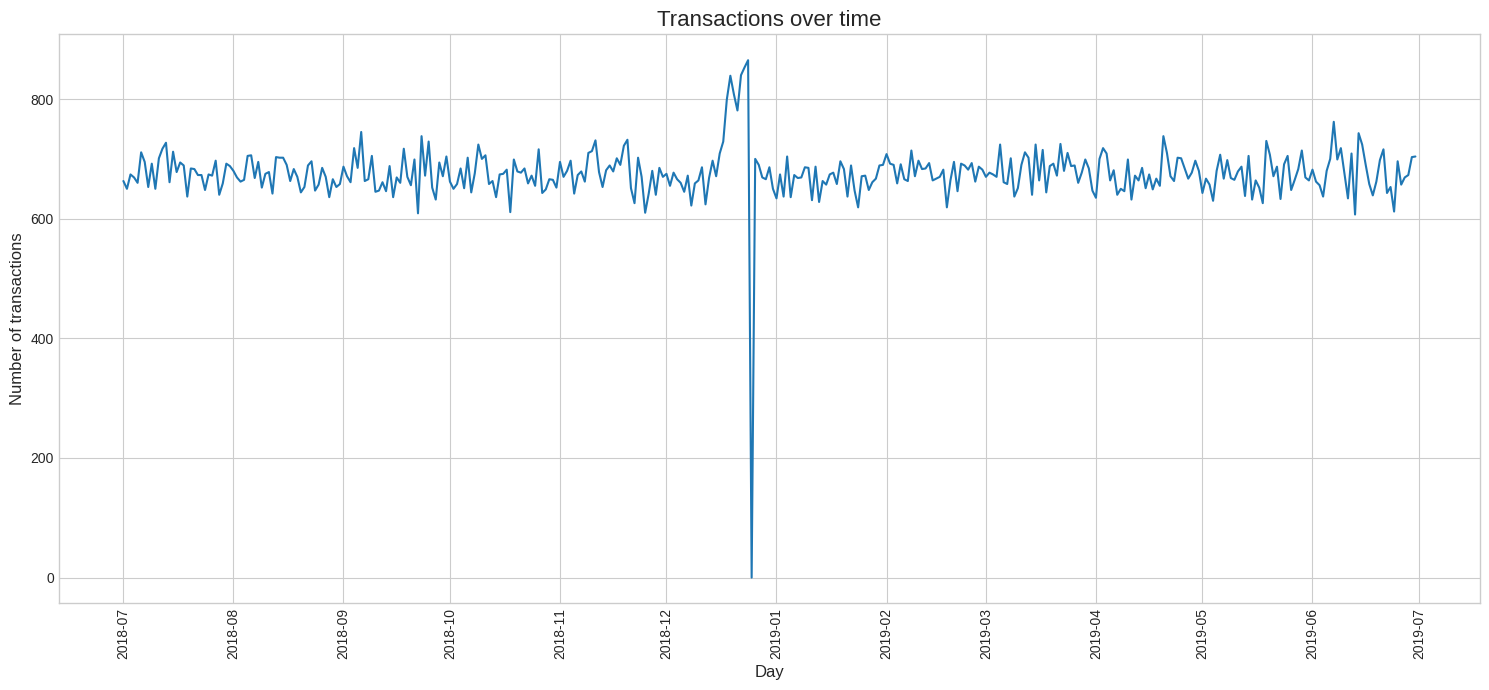

In [19]:
from datetime import datetime, timedelta
from matplotlib.dates import MonthLocator, DateFormatter

# Create a sequence of dates
start_date = datetime(2018, 7, 1)
end_date = datetime(2019, 6, 30)
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
allDates = pd.DataFrame({'DATE': all_dates})

# Count transactions by date
transactions_by_day = transaction_df.groupby('DATE').size().reset_index(name='N')

# Merge all dates with transaction counts
transactions_by_day = pd.merge(allDates, transactions_by_day, on='DATE', how='left')

# Fill NaN values with 0 for days with no transactions
transactions_by_day['N'] = transactions_by_day['N'].fillna(0)

# Set up the plot style
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Create the plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=transactions_by_day, x='DATE', y='N')
plt.title('Transactions over time', fontsize=16, ha='center')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Number of transactions', fontsize=12)

# Format x-axis
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()


We can see that there is an increase in purchases in December and a break in late December. Let’s zoom in
on this.


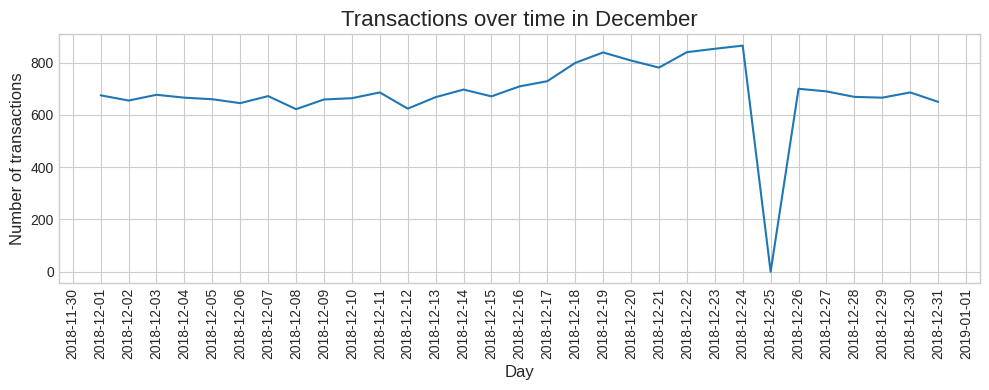

In [20]:
#Filter to December and look at individual days
from matplotlib.dates import DayLocator, DateFormatter
december_transactions = transactions_by_day[transactions_by_day['DATE'].dt.month == 12]

# Set up the plot style
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 4))
sns.lineplot(data=december_transactions, x='DATE', y='N')

# Customize the plot
plt.title('Transactions over time in December', fontsize=16, ha='center')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Number of transactions', fontsize=12)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(DayLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on
Christmas day itself. This is due to shops being closed on Christmas day.


In [21]:
# Sample parse_number function (you need to define the actual logic)
def parse_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[0]) if numbers else None

# Applying the parse_number function to create PACK_SIZE column
transaction_df['PACK_SIZE'] = transaction_df['PROD_NAME'].apply(parse_number)

transaction_df.head(5)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [22]:
 #Group by PACK_SIZE and count the occurrences
pack_size_counts = transaction_df.groupby('PACK_SIZE').size().reset_index(name='N')

# Sort the results by PACK_SIZE
sorted_pack_size_counts = pack_size_counts.sort_values(by='PACK_SIZE')
sorted_pack_size_counts.head(2)

,PACK_SIZE,N
0,70,1507
1,90,3008


The largest size is 380g and the smallest size is 70g - seems sensible!

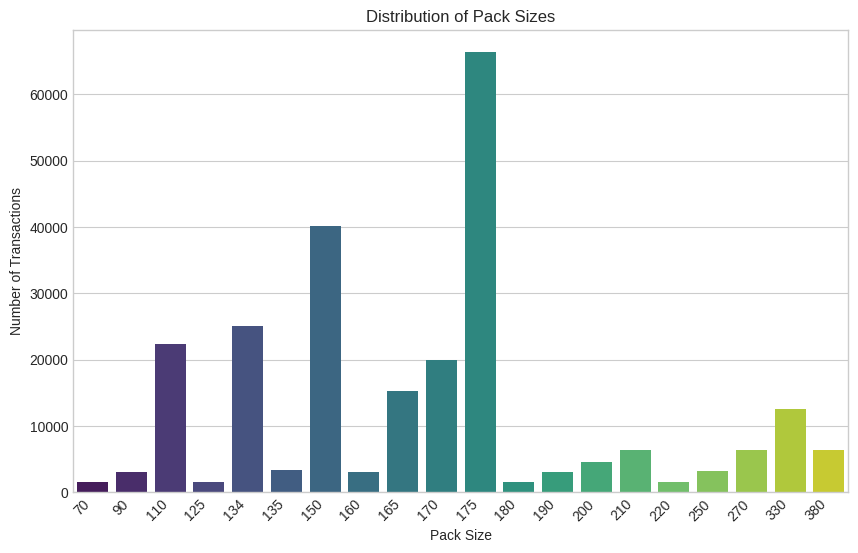

In [23]:
#Let's plot a histogram of PACK_SIZE since we know that it is a categorical
#variable and not a continuous variable even though it is numeric.

# Group by PACK_SIZE and count transactions
summary = transaction_df.groupby('PACK_SIZE').size().reset_index(name='no_of_transactions')

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='PACK_SIZE', y='no_of_transactions', data=summary, palette='viridis')
plt.xlabel('Pack Size')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Pack Sizes', ha='center')
plt.xticks(rotation=45, ha='right')
plt.show()


Pack sizes created look reasonable and now to create brands, we can use the first word in PROD_NAME to work out the brand name.

In [24]:
# Extracting brand names and converting to uppercase
def extract_brand(name):
    match = re.search(r'\s', name)
    if match:
        return name[:match.start()].upper()
    return name.upper()

transaction_df['BRAND'] = transaction_df['PROD_NAME'].apply(extract_brand)

# Group by BRAND and count the occurrences
brand_counts = transaction_df.groupby('BRAND').size().reset_index(name='Count')

# Sort the results by count in descending order
sorted_brand_counts = brand_counts.sort_values(by='Count', ascending=False)
sorted_brand_counts.head(2)



,BRAND,Count
12,KETTLE,41288
19,SMITHS,27390


Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red
Rock Deli chips. Let’s combine these together

In [25]:
# Clean brand names
brand_replacements = {
    "RED": "RRD",
    "SNBTS": "SUNBITES",
    "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS",
    "SMITH": "SMITHS",
    "NCC": "NATURAL",
    "DORITO": "DORITOS",
    "GRAIN": "GRNWVES"
}

transaction_df['BRAND'] = transaction_df['BRAND'].replace(brand_replacements)

# Group by BRAND and count the occurrences
brand_counts = transaction_df.groupby('BRAND').size().reset_index(name='N')

# Sort the results by BRAND
sorted_brand_counts = brand_counts.sort_values(by='BRAND')
print(sorted_brand_counts)

         BRAND      N
0       BURGER   1564
1          CCS   4551
2      CHEETOS   2927
3     CHEEZELS   4603
4         COBS   9693
5      DORITOS  25224
6       FRENCH   1418
7      GRNWVES   7740
8    INFUZIONS  14201
9       KETTLE  41288
10     NATURAL   7469
11    PRINGLES  25102
12         RRD  16321
13      SMITHS  30353
14    SUNBITES   3008
15       THINS  14075
16    TOSTITOS   9471
17    TWISTIES   9454
18    TYRRELLS   6442
19  WOOLWORTHS  11836


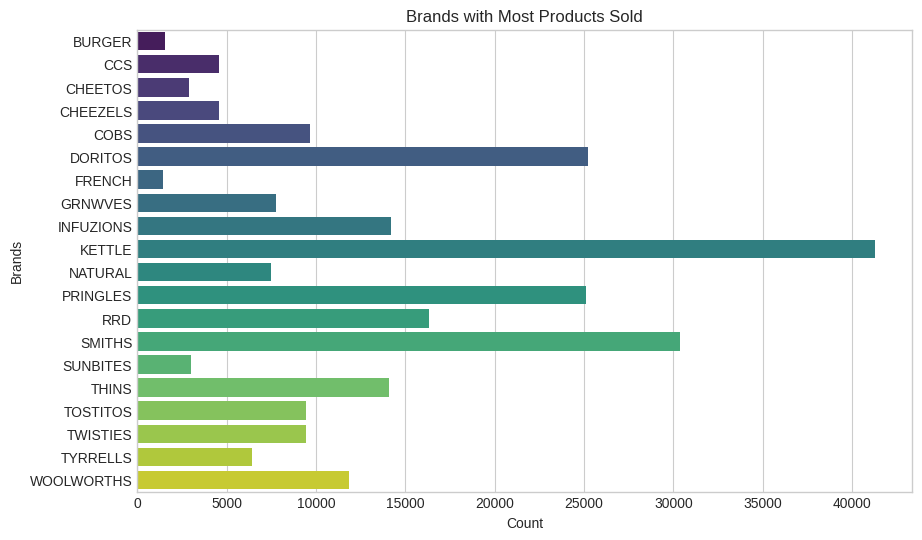

In [26]:
# Group by BRAND and count the occurrences
brand_counts = transaction_df.groupby('BRAND').size().reset_index(name='count')
# Sort the results by BRAND
sorted_brand_counts = brand_counts.sort_values(by='BRAND')
# Visualize the sorted brand counts using Seaborn
sns.barplot(data=sorted_brand_counts, y='BRAND', x='count', palette='viridis')
plt.title('Brands with Most Products Sold')
plt.xlabel('Count')
plt.ylabel('Brands')
plt.show()


#Examining customer data


In [27]:
# Examining customer data
behaviour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [28]:
behaviour_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


Let’s have a closer look at the LIFESTAGE and PREMIUM_CUSTOMER columns.

In [29]:
# Examining the values of lifestage and premium_customer
# Group by LIFESTAGE and count the occurrences
lifestage_counts = behaviour_df.groupby('LIFESTAGE').size().reset_index(name='N')

sorted_lifestage_counts = lifestage_counts.sort_values(by='N', ascending=False)
print(sorted_lifestage_counts)


                LIFESTAGE      N
4                RETIREES  14805
3   OLDER SINGLES/COUPLES  14609
6   YOUNG SINGLES/COUPLES  14441
2          OLDER FAMILIES   9780
5          YOUNG FAMILIES   9178
0  MIDAGE SINGLES/COUPLES   7275
1            NEW FAMILIES   2549


In [30]:
# Group by PREMIUM_CUSTOMER and count the occurrences
premium_customer_counts = behaviour_df.groupby('PREMIUM_CUSTOMER').size().reset_index(name='N')

# Sort the results by N in descending order
sorted_premium_customer_counts = premium_customer_counts.sort_values(by='N', ascending=False)
print(sorted_premium_customer_counts)

  PREMIUM_CUSTOMER      N
1       Mainstream  29245
0           Budget  24470
2          Premium  18922


As there do not seem to be any issues with the customer data, we can now go ahead and join the transaction
and customer data sets together


In [31]:
#Merge transaction data to customer data
merged_data = pd.merge(transaction_df, behaviour_df, on='LYLTY_CARD_NBR', how='left')

merged_data.head(2)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget


In [32]:
merged_data.shape

(246740, 12)

Let’s check if some customers were not matched on by checking for nulls.

In [33]:
merged_data.isnull().sum()

,0
DATE,0
STORE_NBR,0
LYLTY_CARD_NBR,0
TXN_ID,0
PROD_NBR,0
PROD_NAME,0
PROD_QTY,0
TOT_SALES,0
PACK_SIZE,0
BRAND,0


Great, there are no nulls! So all our customers in the transaction data has been accounted for in the customer
dataset.

#Data analsysis on customer segments

Now that the data is ready for analysis, we can define some metrics of interest to the client:

* Who spends the most on chips (total sales), describing customers by lifestage and how premium their
general purchasing behaviour is
* How many customers are in each segment
* How many chips are bought per customer by segment
* What’s the average chip price by customer segment

We could also ask our data team for more information. Examples are:
* The customer’s total spend over the period and total spend for each transaction to understand what
proportion of their grocery spend is on chips
* Proportion of customers in each customer segment overall to compare against the mix of customers
who purchase chips


Let’s start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and plotting the split by
these segments to describe which customer segment contribute most to chip sales.

In [34]:
# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
# Group by LIFESTAGE and PREMIUM_CUSTOMER and sum the total sales
sales_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales_by_segment

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
0,MIDAGE SINGLES/COUPLES,Budget,33345.70
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25
2,MIDAGE SINGLES/COUPLES,Premium,54443.85
3,NEW FAMILIES,Budget,20607.45
4,NEW FAMILIES,Mainstream,15979.70
5,NEW FAMILIES,Premium,10760.80
6,OLDER FAMILIES,Budget,156863.75
7,OLDER FAMILIES,Mainstream,96413.55
8,OLDER FAMILIES,Premium,75242.60
9,OLDER SINGLES/COUPLES,Budget,127833.60


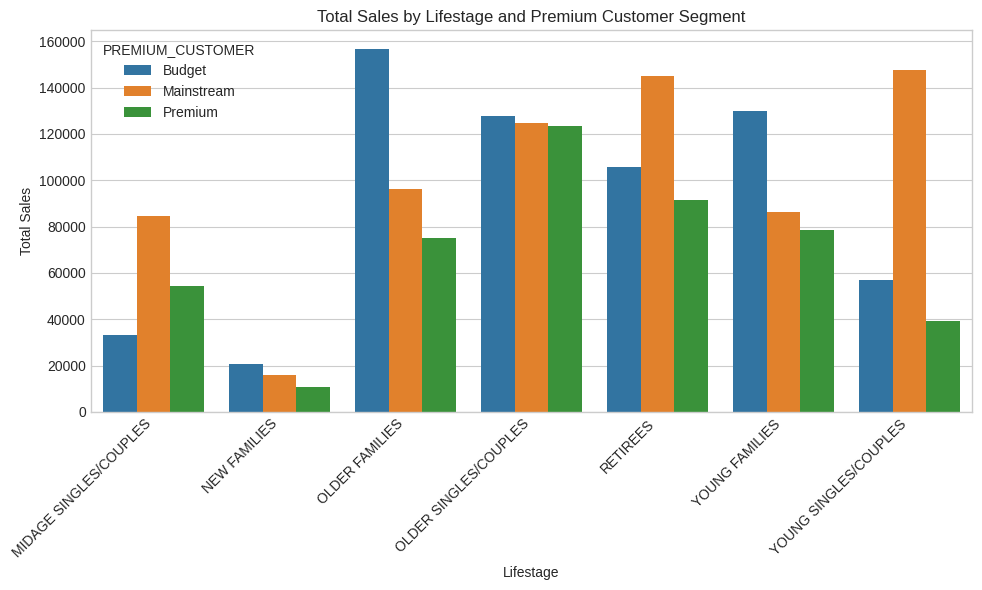

In [35]:
#Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Set the plot style
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_segment, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER')
plt.xlabel('Lifestage')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.title('Total Sales by Lifestage and Premium Customer Segment')
plt.tight_layout()
plt.show()

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream retirees

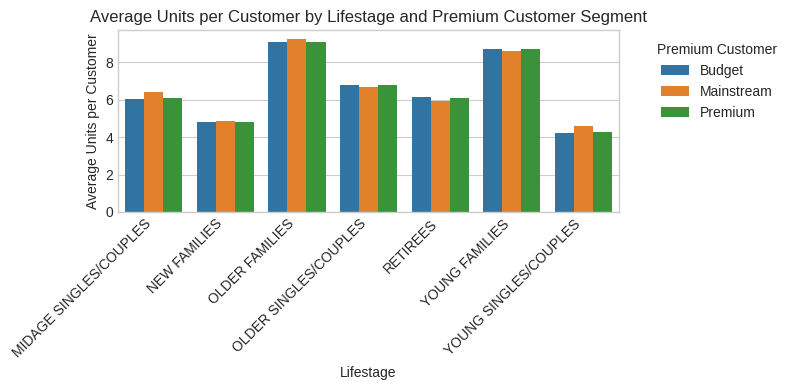

In [38]:
#Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
# Group by LYLTY_CARD_NBR to calculate total PROD_QTY for each customer
total_prod_qty_per_customer = merged_data.groupby('LYLTY_CARD_NBR')['PROD_QTY'].sum().reset_index()

# Merge this total back with the main dataframe to get LIFESTAGE and PREMIUM_CUSTOMER
df_merged = pd.merge(total_prod_qty_per_customer, merged_data[['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']],
                     on='LYLTY_CARD_NBR').drop_duplicates()

# Group by LIFESTAGE and PREMIUM_CUSTOMER to calculate the average PROD_QTY per customer
avg_units_by_segment = df_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean().reset_index()

# Create the plot
plt.figure(figsize=(8, 4))
sns.barplot(data=avg_units_by_segment, x='LIFESTAGE', y='PROD_QTY', hue='PREMIUM_CUSTOMER')
plt.xlabel('Lifestage')
plt.ylabel('Average Units per Customer')
plt.xticks(rotation=45, ha='right')
plt.title('Average Units per Customer by Lifestage and Premium Customer Segment')
plt.legend(title='Premium Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Older families and young families in general buy more chips per customer

Let’s also investigate the average price per unit chips bought for each customer segment as this is also a
driver of total sales.

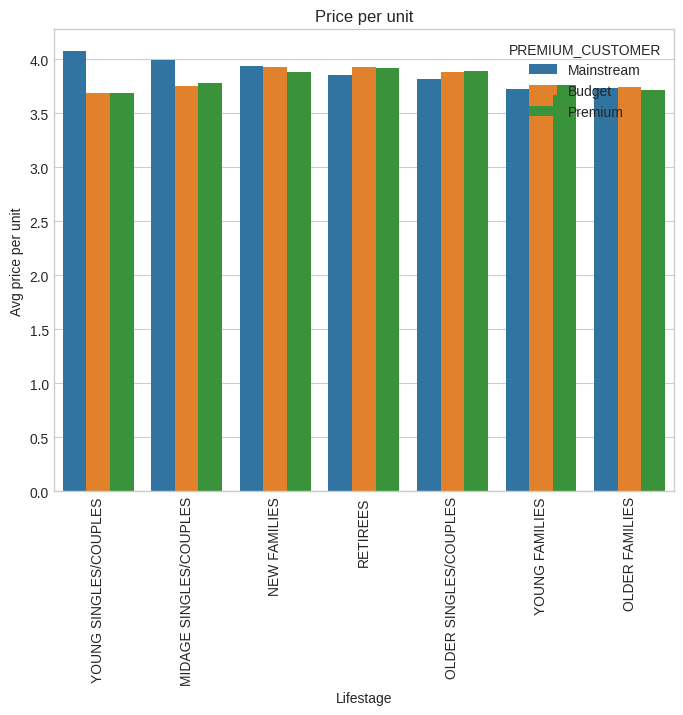

In [41]:
# Calculate the average price per unit
avg_price = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).apply(
    lambda x: pd.Series({
        'AVG': x['TOT_SALES'].sum() / x['PROD_QTY'].sum()
    })
).reset_index()

avg_price = avg_price.sort_values(by='AVG', ascending=False)
# Create the bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(data=avg_price, x='LIFESTAGE',y='AVG',hue='PREMIUM_CUSTOMER',
    dodge=True)

# Set the labels and title
bar_plot.set_xlabel('Lifestage')
bar_plot.set_ylabel('Avg price per unit')
bar_plot.set_title('Price per unit')
plt.xticks(rotation=90)
plt.show()


Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts.
This may be due to premium shoppers being more likely to
buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own
consumption.
This is also supported by there being fewer premium midage and young singles and couples
buying chips compared to their mainstream counterparts

As the difference in average price per unit isn’t large, we can check if this difference is statistically different.

In [42]:
#Perform an independent t‐test between mainstream vs premium and budget
#midage and young singles and couples
from scipy import stats
# Calculate the price per unit
merged_data['price'] = merged_data['TOT_SALES'] / merged_data['PROD_QTY']

# Filter the data for the specified LIFESTAGE groups and PREMIUM_CUSTOMER status
mainstream_group = merged_data[
    (merged_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (merged_data['PREMIUM_CUSTOMER'] == "Mainstream")
]['price']

non_mainstream_group = merged_data[
    (merged_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (merged_data['PREMIUM_CUSTOMER'] != "Mainstream")
]['price']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(mainstream_group, non_mainstream_group, alternative='greater')

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")



T-statistic: 37.83196107667815
P-value: 1.11782280577468e-309


The t-test results in a p-value < 2.2e-16, i.e. the unit price for mainstream, young and mid-age singles and
couples are significantly higher than that of budget or premium, young and midage singles and couples.

#Deep dive into specific customer segments for insights


We have found quite a few interesting insights that we can dive deeper into.
We might want to target customer segments that contribute the most to sales to retain them or further
increase sales. Let’s look at Mainstream - young singles/couples. For instance, let’s find out if they tend to
buy a particular brand of chips.


In [44]:
# Filter the data for the segment "YOUNG SINGLES/COUPLES" and "Mainstream" customers
segment1 = merged_data[(merged_data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") &
                       (merged_data['PREMIUM_CUSTOMER'] == "Mainstream")]

# Filter the data for the rest of the population
other = merged_data[~((merged_data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") &
                      (merged_data['PREMIUM_CUSTOMER'] == "Mainstream"))]

# Calculate the total quantity for segment1 and other
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate the brand proportion for segment1
quantity_segment1_by_brand = segment1.groupby('BRAND').agg(
    targetSegment=pd.NamedAgg(column='PROD_QTY', aggfunc='sum')
).reset_index()
quantity_segment1_by_brand['targetSegment'] /= quantity_segment1

# Calculate the brand proportion for the rest of the population
quantity_other_by_brand = other.groupby('BRAND').agg(
    other=pd.NamedAgg(column='PROD_QTY', aggfunc='sum')
).reset_index()
quantity_other_by_brand['other'] /= quantity_other

# Merge the brand proportions
brand_proportions = pd.merge(quantity_segment1_by_brand, quantity_other_by_brand, on='BRAND')

# Calculate the brand affinity
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']

# Sort by brand affinity in descending order
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)
brand_proportions.head(2)


,BRAND,targetSegment,other,affinityToBrand
18,TYRRELLS,0.031553,0.025692,1.228095
17,TWISTIES,0.046184,0.037877,1.219319


We can see that :
* Mainstream young singles/couples are 23% more likely to purchase Tyrrells chips compared to the
rest of the population
* Mainstream young singles/couples are 56% less likely to purchase Burger Rings compared to the rest
of the population


Let’s also find out if our target segment tends to buy larger packs of chips.

In [45]:
# Preferred pack size compared to the rest of the population
# Filter the data for the segment "YOUNG SINGLES/COUPLES" and "Mainstream" customers
segment1 = merged_data[(merged_data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") &
                       (merged_data['PREMIUM_CUSTOMER'] == "Mainstream")]

# Filter the data for the rest of the population
other = merged_data[~((merged_data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") &
                      (merged_data['PREMIUM_CUSTOMER'] == "Mainstream"))]

# Calculate the total quantity for segment1 and other
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate the pack size proportion for segment1
quantity_segment1_by_pack = segment1.groupby('PACK_SIZE').agg(
    targetSegment=pd.NamedAgg(column='PROD_QTY', aggfunc='sum')
).reset_index()
quantity_segment1_by_pack['targetSegment'] /= quantity_segment1

# Calculate the pack size proportion for the rest of the population
quantity_other_by_pack = other.groupby('PACK_SIZE').agg(
    other=pd.NamedAgg(column='PROD_QTY', aggfunc='sum')
).reset_index()
quantity_other_by_pack['other'] /= quantity_other

# Merge the pack proportions
pack_proportions = pd.merge(quantity_segment1_by_pack, quantity_other_by_pack, on='PACK_SIZE')

# Calculate the pack affinity
pack_proportions['affinityToPack'] = pack_proportions['targetSegment'] / pack_proportions['other']

# Sort by pack affinity in descending order
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)
print(pack_proportions)


    PACK_SIZE  targetSegment     other  affinityToPack
17        270       0.031829  0.025096        1.268287
19        380       0.032160  0.025584        1.257030
18        330       0.061284  0.050162        1.221717
4         134       0.119420  0.100635        1.186670
2         110       0.106280  0.089791        1.183637
14        210       0.029124  0.025121        1.159318
5         135       0.014769  0.013075        1.129511
16        250       0.014355  0.012781        1.123166
9         170       0.080773  0.080986        0.997370
6         150       0.157598  0.163421        0.964372
10        175       0.254990  0.270007        0.944382
8         165       0.055652  0.062268        0.893757
12        190       0.007481  0.012442        0.601271
11        180       0.003589  0.006067        0.591538
7         160       0.006404  0.012373        0.517616
1          90       0.006349  0.012580        0.504698
3         125       0.003009  0.006037        0.498442
13        

It looks like Mainstream young singles/couples are 27% more likely to purchase a 270g pack of chips compared to the rest of the population but let’s dive into what brands sell this pack size.


In [46]:
# Filter the DataFrame for rows where PACK_SIZE is 270 and get unique PROD_NAME values
unique_prod_names = merged_data[merged_data['PACK_SIZE'] == 270]['PROD_NAME'].unique()

# Display the unique product names
print(unique_prod_names)


['Twisties Cheese     270g' 'Twisties Chicken270g']


Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of
purchasing Twisties.

#Conclusion

Let’s recap what we’ve found!
* Sales have mainly been due to Budget - older families, Mainstream - young singles/couples, and Mainstream retirees shoppers.

* We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers.
* Mainstream, midage and young singles and couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour.

* We’ve also found that Mainstream young singles and couples are 23% more likely to purchase Tyrrells chips compared to the rest of the population. The Category Manager may want to increase the category’s performance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments where young singles and couples frequent more often to increase visibilty and impulse behaviour.

* Quantium can help the Category Manager with recommendations of where these segments are and further help them with measuring the impact of the changed placement.